# Real and Fake Face detection
In this replository is a small application that uses a CNN to predict real or fake face.

Data has been collected from kaggle. For training ~1450 images and with an additional ~300 images for validation.

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D
import numpy as np
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

# Dataset

First let's load in the data I've collected from the program. I will use kera's ImageDataGenerator to not only label the data from the directories but also to slightly augment the data with shifts, rotations, zooms, and mirroring. Mirroring will help to ensure that the data are not biased to a particular handedness.

In [5]:
nbatch = 128
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory('dataset/training',
                                                 target_size=(128, 128),
                                                 batch_size=nbatch,
                                                 class_mode='binary',
                                                 color_mode='rgb')

test_set = test_datagen.flow_from_directory('dataset/test',
                                            target_size=(128, 128),
                                            batch_size=nbatch,
                                            class_mode='binary',
                                            color_mode='rgb')

Found 1436 images belonging to 2 classes.
Found 604 images belonging to 2 classes.


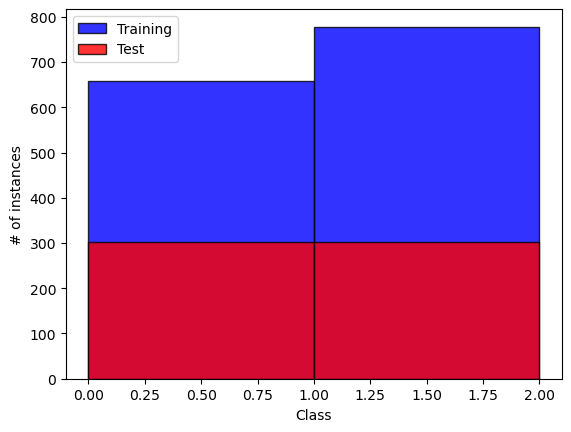

In [9]:
# Visualize class distributions
plt.hist(training_set.classes, bins=range(0, 3), alpha=0.8, color='blue', edgecolor='black', label='Training')
plt.hist(test_set.classes, bins=range(0, 3), alpha=0.8, color='red', edgecolor='black', label='Test')
plt.ylabel('# of instances')
plt.xlabel('Class')
plt.legend()
plt.show()

(128, 128, 128, 3) (128,)


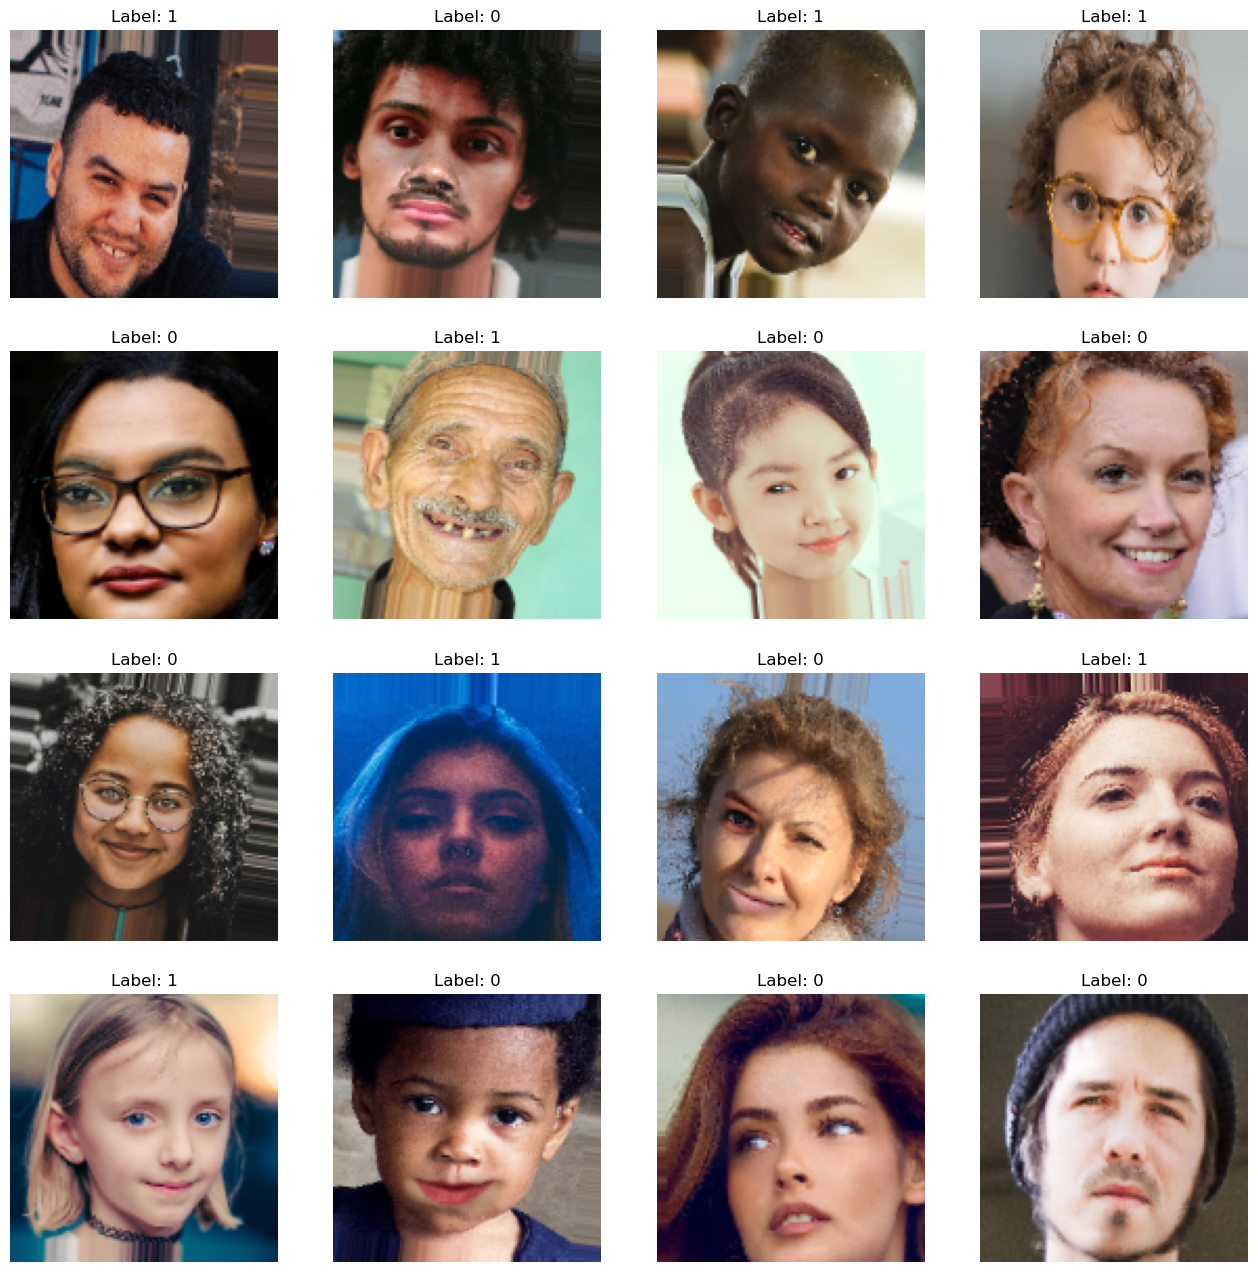

In [11]:
for X, y in training_set:
    print(X.shape, y.shape)
    plt.figure(figsize=(16, 16))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.axis('off')
        plt.title(f'Label: {int(y[i])}')
        plt.imshow(X[i])  # Adjusted for RGB
    break

# Convolutional Neural Net
The data looks resonable so now I will define a CNN model to train and use within our application.

In [14]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

C:\Users\nikit\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape        ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv2d (Conv2D)             │ (None, 126, 126,    │         896 │
│                             │ 32)                 │             │
├─────────────────────────────┼─────────────────────┼─────────────┤
│ max_pooling2d               │ (None, 63, 63, 32)  │           0 │
│ (MaxPooling2D)              │                     │             │
├─────────────────────────────┼─────────────────────┼─────────────┤
│ conv2d_1 (Conv2D)           │ (None, 61, 61, 64)  │      18,496 │
├─────────────────────────────┼─────────────────────┼─────────────┤
│ max_pooling2d_1             │ (None, 30, 30, 64)  │           0 │
│ (MaxPooling2D)              │                     │             │
├─────────────────────────────┼─────────────────────┼─────────────┤
│ conv2d_2 (Conv2D)           │ (None, 28, 28, 128) │      73,856 │
├─────────────────────────────┼─────────────────────┼─────────────┤
│ max_pooling2d_2             │ (None, 14, 14, 128) │           0 │
│ (MaxPooling2D)              │                     │             │
├─────────────────────────────┼─────────────────────┼─────────────┤
│ flatten (Flatten)           │ (None, 25088)       │           0 │
├─────────────────────────────┼─────────────────────┼─────────────┤
│ dense (Dense)               │ (None, 256)         │   6,422,784 │
├─────────────────────────────┼─────────────────────┼─────────────┤
│ dense_1 (Dense)             │ (None, 1)           │         257 │
└─────────────────────────────┴─────────────────────┴─────────────┘

 Total params: 6,516,289 (24.86 MB)

 Trainable params: 6,516,289 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

##### Compile the model

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training
Finally we will train our model using some keras helper functions. We are not doing any hyper-parameter optimization so we will not define a separate testing and validation set. We can however evaluate our model further in real time within the application.

In [20]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(filepath='model_checkpoint.keras', monitor='val_loss', save_best_only=True, mode='max')
]

In [22]:
import os
from PIL import Image

def clean_directory(directory):
    for subdir, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verify that it is a valid image file
            except (IOError, SyntaxError):
                print(f"Removing bad file: {file_path}")
                os.remove(file_path)  # Remove if not an image

# Apply to training and test directories
clean_directory('dataset/training')
clean_directory('dataset/test')


In [24]:
import os

def remove_missing_files(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if not os.path.isfile(file_path):
                print(f"Missing file detected and removed from reference: {file_path}")

# Run on training and test sets
remove_missing_files('dataset/training')
remove_missing_files('dataset/test')


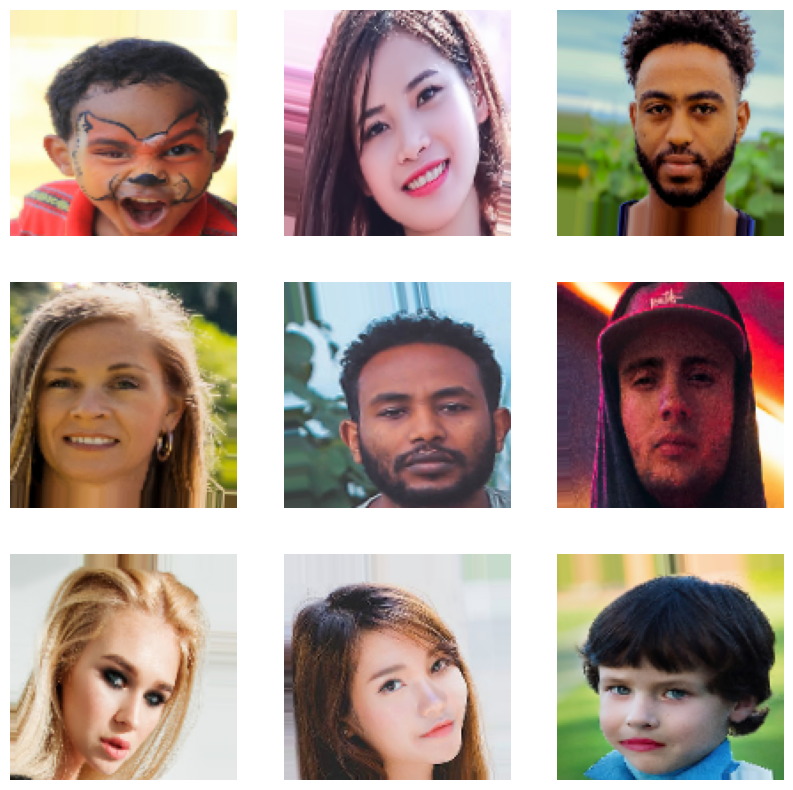

In [26]:
import matplotlib.pyplot as plt

# Preview a batch to verify image loading
for X_batch, y_batch in training_set:
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(X_batch[i])
        plt.axis('off')
    break
plt.show()


In [28]:
import os

def check_missing_files(directory):
    missing_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if not os.path.isfile(file_path):
                missing_files.append(file_path)
    return missing_files

# Check both training and test directories
missing_training_files = check_missing_files('dataset/training')
missing_test_files = check_missing_files('dataset/test')

print("Missing training files:", missing_training_files)
print("Missing test files:", missing_test_files)


Missing training files: []
Missing test files: []


In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Reinitialize the generator
train_datagen = ImageDataGenerator(rescale=1./255)
training_set = train_datagen.flow_from_directory(
    'dataset/training',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)


Found 1436 images belonging to 2 classes.


In [32]:
steps_per_epoch = training_set.samples // training_set.batch_size
validation_steps = test_set.samples // test_set.batch_size


In [34]:
history = model.fit(
    training_set,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=test_set,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)

C:\Users\nikit\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.5062 - loss: 0.8455 - val_accuracy: 0.4941 - val_loss: 0.6926
Epoch 2/10
 1/44 ━━━━━━━━━━━━━━━━━━━━ 14s 336ms/step - accuracy: 0.4375 - loss: 0.6951

C:\Users\nikit\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.4375 - loss: 0.6951 - val_accuracy: 0.5326 - val_loss: 0.6916
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.5386 - loss: 0.6928 - val_accuracy: 0.4980 - val_loss: 0.6935
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.6562 - loss: 0.6667 - val_accuracy: 0.5109 - val_loss: 0.6860
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.5254 - loss: 0.6920 - val_accuracy: 0.5273 - val_loss: 0.6884
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.5625 - loss: 0.6792 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5617 - loss: 0.6848 - val_accuracy: 0.5605 - val_loss: 0.6822
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5938 - loss: 0.6809 - val_accuracy: 0.5761 - val_loss: 0.6706
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 659ms/step - accuracy: 0.6284 - loss: 0.6645 - val_accuracy: 0.5645 - val_loss: 0.6

In [36]:
training_set.class_indices

{'fake': 0, 'real': 1}

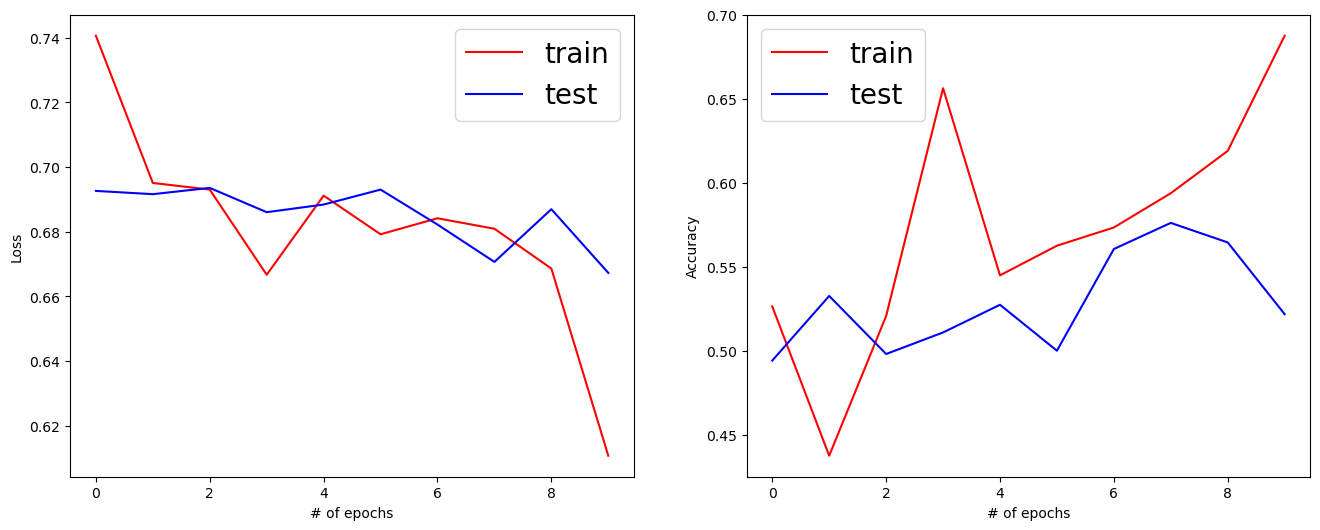

In [38]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
nepochs = len(history.history['loss'])
plt.plot(range(nepochs), history.history['loss'], 'r-', label='train')
plt.plot(range(nepochs), history.history['val_loss'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('Loss')
plt.xlabel('# of epochs')

plt.subplot(1, 2, 2)
plt.plot(range(nepochs), history.history['accuracy'], 'r-', label='train')
plt.plot(range(nepochs), history.history['val_accuracy'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('Accuracy')
plt.xlabel('# of epochs')
plt.show()


# Prediction
Now the model is trained so I used some real images and edited that image so that we can analysis model is working correcly or not.

In [41]:
def ImagePrediction(loc):
    test_image = image.load_img(loc, target_size=(128, 128))
    plt.axis('off')
    plt.imshow(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    result = model.predict(test_image)
    predictions = 'Real' if result[0][0] == 1 else 'Fake'
    print('Prediction:', predictions)

Enter Location of Image to predict:  C:\Users\nikit\OneDrive\Desktop\fake face detection\Fake Face\fakeface\dataset\face_pred\check.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Prediction: Real


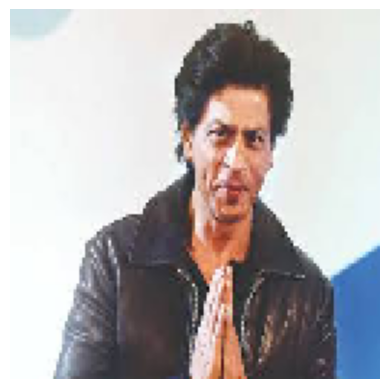

In [63]:
img = input("Enter Location of Image to predict: ")
test_image_1 = ImagePrediction(img)

Enter location of image to predict:  C:\Users\nikit\OneDrive\Desktop\fake face detection\Fake Face\fakeface\dataset\face_pred\check2.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction: Fake


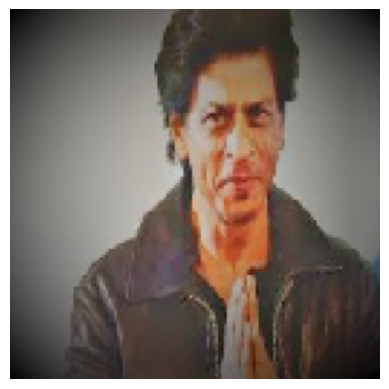

In [73]:
img = input("Enter location of image to predict: ")
ImagePrediction(img)

Enter location of image to predict:  C:\Users\nikit\OneDrive\Desktop\fake face detection\Fake Face\fakeface\dataset\face_pred\check3.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction: Fake


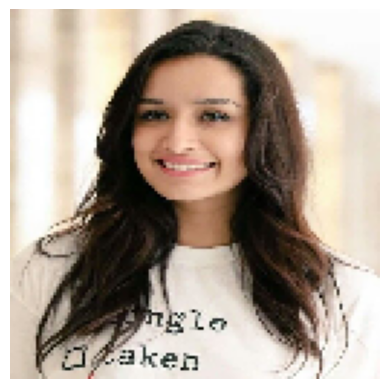

In [75]:
img = input("Enter location of image to predict: ")
ImagePrediction(img)

Enter location of image to predict:  C:\Users\nikit\OneDrive\Desktop\fake face detection\Fake Face\fakeface\dataset\face_pred\check4.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction: Real


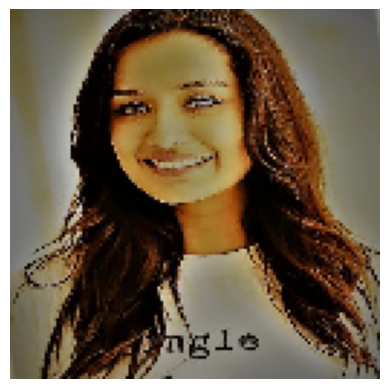

In [71]:
img = input("Enter location of image to predict: ")
ImagePrediction(img)

## Result
3 out of 4 images is predicted correctly althrough model is not trained well by incereasing epoc near about 40 will probably make this model perfectly trained but that will require 5-6hr for training.